# q3fer/distilbert-base-fallacy-classification

In [2]:
# Install dependencies (run once)
!pip install transformers

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TextClassificationPipeline 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
import mlflow
from mlflow.transformers import log_model
import logging 
from logging import getLogger
from transformers import AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import torch


from sklearn.model_selection import train_test_split
#  import pickle
import warnings # why? 
from mlflow.sklearn import save_model 
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # This tells Hugging Face: “Don’t use parallel tokenization — avoid possible deadlocks.”

import seaborn as sns
import matplotlib.pyplot as plt

import config 

/Users/alicepope/Capstone project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# # Load model config to inspect label mappings

# model_name = "q3fer/distilbert-base-fallacy-classification"
# configuration = AutoConfig.from_pretrained(model_name)

# print("Model Label ID to Label Mapping:")
# print(configuration.id2label)

# print("\nReverse Mapping (Label to ID):")
# print(configuration.label2id)

Model Label ID to Label Mapping:
{0: 'ad hominem', 1: 'ad populum', 2: 'appeal to emotion', 3: 'circular reasoning', 4: 'equivocation', 5: 'fallacy of credibility', 6: 'fallacy of extension', 7: 'fallacy of logic', 8: 'fallacy of relevance', 9: 'false causality', 10: 'false dilemma', 11: 'faulty generalization', 12: 'intentional', 13: 'miscellaneous'}

Reverse Mapping (Label to ID):
{'ad hominem': 0, 'ad populum': 1, 'appeal to emotion': 2, 'circular reasoning': 3, 'equivocation': 4, 'fallacy of credibility': 5, 'fallacy of extension': 6, 'fallacy of logic': 7, 'fallacy of relevance': 8, 'false causality': 9, 'false dilemma': 10, 'faulty generalization': 11, 'intentional': 12, 'miscellaneous': 13}


In [4]:
MODEL_NAME = "q3fer/distilbert-base-fallacy-classification" # pulls the fallacy trained model
DATA_PATH = "../data/data_small.csv"
TRACKING_URI = config.TRACKING_URI
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [5]:
# Load and preprocess data
logger.info("Loading and preprocessing data...")
df = pd.read_csv(DATA_PATH)
le = LabelEncoder()
df["label"] = le.fit_transform(df["logical_fallacies"])
dataset = Dataset.from_pandas(df[["text", "label"]])
dataset = dataset.train_test_split(test_size=0.3)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

dataset = dataset.map(tokenize, batched=True)

2025-04-02 17:15:50,968: Loading and preprocessing data...
Map: 100%|██████████| 1500/1500 [00:00<00:00, 2674.40 examples/s]


In [ ]:
print(le.classes_)  
print(le.inverse_transform([0,1,2,3,4,5]))

['ad_hominem' 'appeal_to_authority' 'appeal_to_emotion' 'false_dilemma'
 'faulty_generalization' 'none']
['ad_hominem' 'appeal_to_authority' 'appeal_to_emotion' 'false_dilemma'
 'faulty_generalization' 'none']


In [7]:
# Define new labels
id2label = {
    0: "ad_hominem",
    1: "appeal_to_authority",
    2: "appeal_to_emotion",
    3: "false_dilemma",
    4: "faulty_generalization",
    5: "none"
}

label2id = {v: k for k, v in id2label.items()}

In [16]:
# Initialize model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=6, ignore_mismatched_sizes= True)
model.config.id2label = id2label
model.config.label2id = label2id

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at q3fer/distilbert-base-fallacy-classification and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([14, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([14]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
final_layer = model.classifier
# Check the size of the weights
print(final_layer.weight.shape)  # Will be [num_labels, hidden_size] (num_labels x hidden_size)

torch.Size([6, 768])


In [18]:
# To see a summary of the model
print(model.config)

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "ad_hominem",
    "1": "appeal_to_authority",
    "2": "appeal_to_emotion",
    "3": "false_dilemma",
    "4": "faulty_generalization",
    "5": "none"
  },
  "initializer_range": 0.02,
  "label2id": {
    "ad_hominem": 0,
    "appeal_to_authority": 1,
    "appeal_to_emotion": 2,
    "false_dilemma": 3,
    "faulty_generalization": 4,
    "none": 5
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.50.3",
  "vocab_size": 30522
}



In [19]:
# Define metric logging function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro")
    recall = recall_score(labels, preds, average="macro")
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [25]:
# TrainingArguments This config tells the Trainer: 
# “Train for 3 epochs, evaluate and save the model after each one, 
# use moderate batch sizes, 
# and keep logs and checkpoints local — don’t auto-report to external dashboards.” --> can it be set to report to MLFlow?

args = TrainingArguments(
    output_dir="../models/fallacy-model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    logging_dir="./logs",
    save_strategy="epoch",
    report_to="none"
)

/Users/alicepope/Capstone project/Capstone_project/backend/.venv/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
# Train using Trainer and log to MLflow
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
with mlflow.start_run():
    mlflow.set_tag("model_name", MODEL_NAME)
    mlflow.log_params({"epochs" : 1})
    trainer = Trainer(
        model,
        args=args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    trainer.evaluate()

    # Wrap model in a Hugging Face pipeline so MLflow can log it properly
    pipeline = TextClassificationPipeline(model=trainer.model, tokenizer=tokenizer)
    log_model(pipeline, artifact_path="model") 


/var/folders/qt/8rxmyyc907sdnc599f4rg0080000gn/T/ipykernel_78819/1737596100.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.840560,0.728000,0.726316,0.620646,0.659076
2,No log,0.946859,0.734000,0.706488,0.657442,0.673988
3,0.441400,1.043909,0.736667,0.710476,0.657193,0.678199


Device set to use cpu
2025/04/02 20:09:32 WARNING mlflow.transformers.signature: An unsupported task type was supplied for signature inference. Either provide an `input_example` or generate a signature manually via `infer_signature` to have a signature recorded in the MLmodel file.
2025/04/02 20:09:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/qt/8rxmyyc907sdnc599f4rg0080000gn/T/tmpj38vqu0z/model, flavor: transformers). Fall back to return ['transformers==4.50.3', 'torch==2.2.2', 'torchvision==0.17.2', 'accelerate==1.5.2']. Set logging level to DEBUG to see the full traceback. 
2025/04/02 20:09:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


                       precision    recall  f1-score   support

           ad_hominem       0.77      0.58      0.66       154
  appeal_to_authority       0.64      0.54      0.59        90
    appeal_to_emotion       0.64      0.75      0.69       207
        false_dilemma       0.75      0.68      0.71       140
faulty_generalization       0.68      0.54      0.60       194
                 none       0.78      0.86      0.82       715

             accuracy                           0.74      1500
            macro avg       0.71      0.66      0.68      1500
         weighted avg       0.74      0.74      0.73      1500

Confusion Matrix:
[[ 89   6  27   3   8  21]
 [  4  49  12   1   3  21]
 [  8   4 155   5   5  30]
 [  2   0   3  95   4  36]
 [  3   2  16   2 104  67]
 [ 10  16  28  20  28 613]]


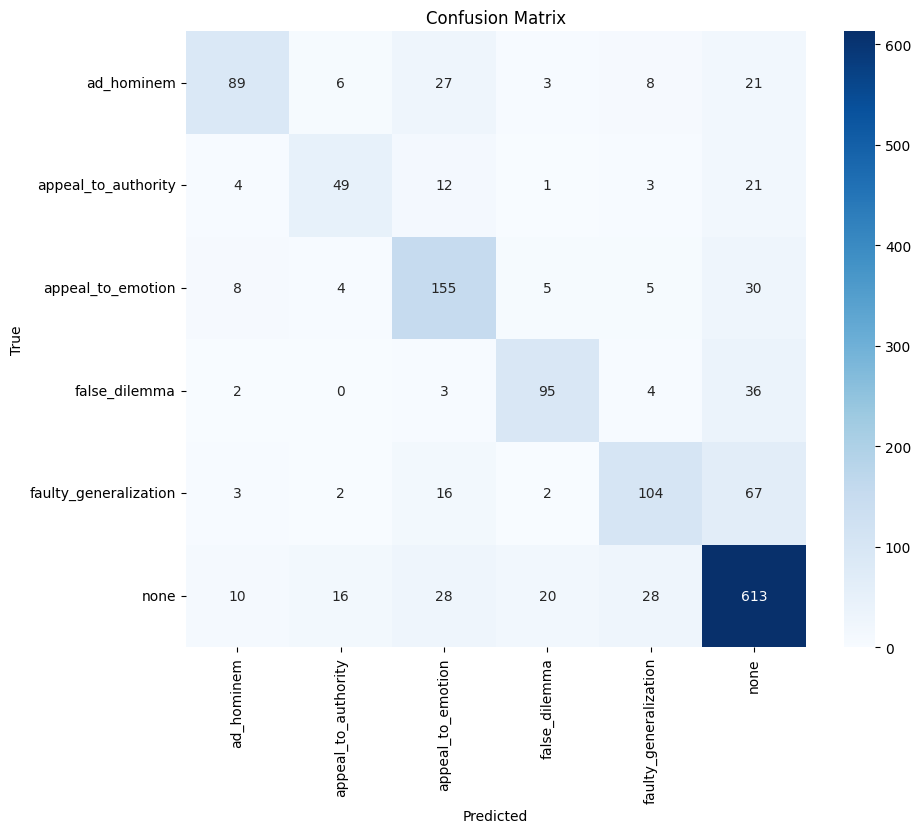

In [27]:
# Add prediction and reporting here
output = trainer.predict(dataset["test"])
predictions = np.argmax(output.predictions, axis=1)
y_true = output.label_ids

# Classification report
label_names = le.classes_
print(classification_report(y_true, predictions, target_names=label_names))

# Confusion matrix
cm = confusion_matrix(y_true, predictions)
print("Confusion Matrix:")
print(cm)

# plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [28]:
path = "../models/distilbert-base-fallacy-classification"
save_model(sk_model=model, path=path)

2025/04/02 20:24:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


### Checking the q3fer

In [19]:
# Run inference with q3fer model on sample texts
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer)

examples = [
    "You have no idea what you're talking about; you've only lived here for six months.", # ad_hominem
    "I read a book by a nutritionist who says all carbs are bad.", # appeal_to_authority
    "Can I have the last piece of cake? You know how much I love it, and it's been a tough day for me.", # appeal_to_emotion
    "If we don't order pizza for dinner, we'll have to eat the week-old spaghetti in the fridge.", # false_dilemma
    "I was in Greece for two week. Greeks are amazing people!", # faulty_generalization
    "We should look into the science that supports this idea." # none
]

predictions = pipeline(examples)

for i, pred in enumerate(predictions):
    print(f"Text {i+1}: {examples[i]}")
    print(f"Prediction: {pred['label']} (Score: {pred['score']:.2f})")
    print("-" * 50)

Device set to use cpu


Text 1: You have no idea what you're talking about; you've only lived here for six months.
Prediction: ad hominem (Score: 0.95)
--------------------------------------------------
Text 2: I read a book by a nutritionist who says all carbs are bad.
Prediction: fallacy of credibility (Score: 0.49)
--------------------------------------------------
Text 3: Can I have the last piece of cake? You know how much I love it, and it's been a tough day for me.
Prediction: appeal to emotion (Score: 0.69)
--------------------------------------------------
Text 4: If we don't order pizza for dinner, we'll have to eat the week-old spaghetti in the fridge.
Prediction: faulty generalization (Score: 0.97)
--------------------------------------------------
Text 5: I was in Greece for two week. Greeks are amazing people!
Prediction: faulty generalization (Score: 0.99)
--------------------------------------------------
Text 6: We should look into the science that supports this idea.
Prediction: fallacy of c

In [ ]:
label_mapping = {
    'ad hominem': 'ad_hominem',
    'appeal to emotion': 'appeal_to_emotion',
    'false dilemma': 'false_dilemma',
    'faulty generalization': 'faulty_generalization',
    'circular reasoning': 'other',
    'appeal to authority': 'appeal_to_authority',  
    'miscellaneous': 'other',  
    'fallacy of logic': 'other',
    'intentional': 'other',
    'ad populum': 'other',
    'equivocation': 'other',
    'false causality': 'other',
    'fallacy of relevance': 'other',
    'fallacy of credibility': 'other',
    'fallacy of extension': 'other'
}

#  the model's label doesn't include 'none'.Maybe we should/could test it out on our dataset with only the fallacies?

In [22]:
# testing with the examples
mapped_predictions = []

for i, pred in enumerate(predictions):
    original_label = pred['label']
    mapped_label = label_mapping.get(original_label, 'unmapped')

    print(f"Text {i+1}: {examples[i]}")
    print(f"Original Prediction: {original_label} (Score: {pred['score']:.2f})")
    print(f"Mapped to: {mapped_label}")
    print("-" * 50)

    mapped_predictions.append(mapped_label)


Text 1: You have no idea what you're talking about; you've only lived here for six months.
Original Prediction: ad hominem (Score: 0.95)
Mapped to: ad_hominem
--------------------------------------------------
Text 2: I read a book by a nutritionist who says all carbs are bad.
Original Prediction: fallacy of credibility (Score: 0.49)
Mapped to: other
--------------------------------------------------
Text 3: Can I have the last piece of cake? You know how much I love it, and it's been a tough day for me.
Original Prediction: appeal to emotion (Score: 0.69)
Mapped to: appeal_to_emotion
--------------------------------------------------
Text 4: If we don't order pizza for dinner, we'll have to eat the week-old spaghetti in the fridge.
Original Prediction: faulty generalization (Score: 0.97)
Mapped to: faulty_generalization
--------------------------------------------------
Text 5: I was in Greece for two week. Greeks are amazing people!
Original Prediction: faulty generalization (Score: 